# Challenge 5

* We measure a spectrum of 10 guassian-distributed variables (`x`), indexed by an energy variable `E`.

* Signal and background are distributed differently in every bin:

    * `b(E)` is constant and equal to `B=60`.
    * `s(E)` follows a gaussian distribution: `s(E) = S*exp((E-E_0) / 2 \sigma_E^2)` with `E_0=4` and `\sigma_E=1`.
    * `S` is unknown and we want to estimate it from the data.
    

E =  [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
x =  [62, 69, 74, 86, 69, 81, 68, 54, 66, 71]


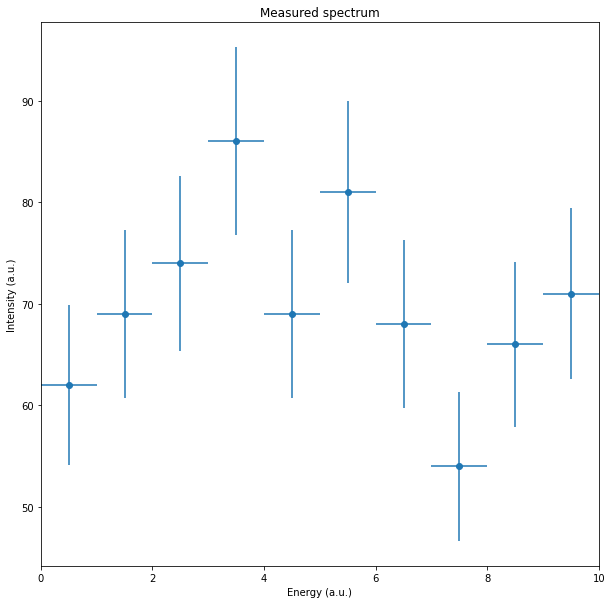

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(
    0
)  # We manually set the seed for reproducible results, this is not required

E = np.arange(0, 10) + 0.5
print("E = ", E)

intensity_data = [62, 69, 74, 86, 69, 81, 68, 54, 66, 71]
print("x = ", intensity_data)

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 10])

ax.set_xlabel("Energy (a.u.)")
ax.set_ylabel("Intensity (a.u.)")
ax.set_title("Measured spectrum")

ax.errorbar(E, intensity_data, xerr=0.5, fmt="o", yerr=np.sqrt(intensity_data))

plt.show()

In [2]:
def fit_func(E, S, E_0=4, sigma_E=1, B=60):
    return B + S * np.exp(-((E - E_0) ** 2) / (2 * sigma_E ** 2))

In [3]:
def chi2_estimator(y, f, sigma):
    result = 0
    for i in range(len(y)):
        result += (y[i] - f[i]) ** 2 / (sigma[i] ** 2)
    return result

We compute the fit function for different values of S to compare the chi2 estimator

S=23.28


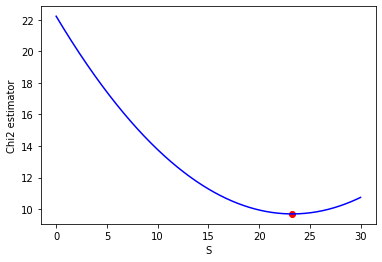

In [4]:
S_values = []
chi2_values = []

chi2_min = 1e10
S_result = 0

for S in np.linspace(0, 30, 10000):
    y = intensity_data
    sigma = np.sqrt(y)
    f = [fit_func(energy, S=S) for energy in E]
    chi2 = chi2_estimator(y, f, sigma)

    S_values.append(S)
    chi2_values.append(chi2)

    if chi2 < chi2_min:
        chi2_min = chi2
        S_result = S

print(f"S={S_result:0.2f}")

plt.plot(S_values, chi2_values, color="blue")
plt.scatter([S_result], [chi2_min], color="red")

plt.xlabel("S")
plt.ylabel("Chi2 estimator")

plt.show()

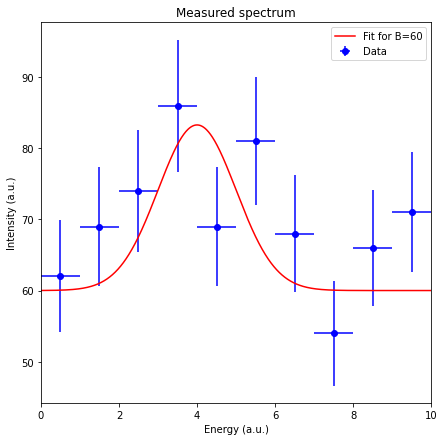

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_xlim([0, 10])

ax.set_xlabel("Energy (a.u.)")
ax.set_ylabel("Intensity (a.u.)")
ax.set_title("Measured spectrum")

ax.errorbar(
    E,
    intensity_data,
    xerr=0.5,
    fmt="o",
    yerr=np.sqrt(intensity_data),
    color="blue",
    label="Data",
)

E_plt = np.linspace(0, 10, 1000)
ax.plot(E_plt, fit_func(E_plt, S=S_result), color="red", label="Fit for B=60")

plt.legend()
plt.show()

### Goodness of fit for B=60

We have 10 data points and one free parameter (S), so the number of degrees of freedom of the chi2 is 9

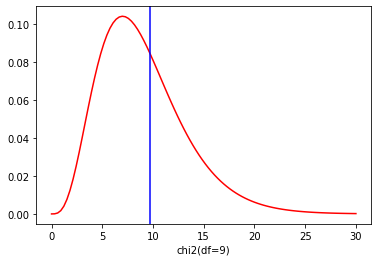

p-value = 0.38


In [6]:
from scipy.stats import chi2

x = np.linspace(0, 30, 100)
y = chi2(df=9).pdf(x)

plt.xlabel("chi2(df=9)")
plt.plot(x, y, color="red")
plt.axvline(x=chi2_min, color="blue")
plt.show()

print(f"p-value = {1 - chi2(df=9).cdf(chi2_min):0.2f}")

### Now with S and B as free parameters

In [ ]:
chi2_min = 1e10
S_result = 0
B_result = 0

for S in np.linspace(12, 35, 200):
    for B in np.linspace(50, 80, 200):
        y = intensity_data
        sigma = np.sqrt(y)
        f = [fit_func(energy, S=S, B=B) for energy in E]
        chi2 = chi2_estimator(y, f, sigma)

        if chi2 < chi2_min:
            chi2_min = chi2
            S_result = S
            B_result = B

print(f"S={S_result:0.2f}, B={B_result:0.2f}")

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_xlim([0, 10])

ax.set_xlabel("Energy (a.u.)")
ax.set_ylabel("Intensity (a.u.)")
ax.set_title("Measured spectrum")

ax.errorbar(
    E,
    intensity_data,
    xerr=0.5,
    fmt="o",
    yerr=np.sqrt(intensity_data),
    color="blue",
    label="Data",
)

E_plt = np.linspace(0, 10, 1000)
ax.plot(
    E_plt,
    fit_func(E_plt, S=S_result, B=B_result),
    color="red",
    label="Fit with S and B as free parameters",
)

plt.legend()
plt.show()

In [ ]:
from scipy.stats import chi2

x = np.linspace(0, 30, 100)
y = chi2(df=8).pdf(x)

plt.xlabel("chi2(df=8)")
plt.plot(x, y, color="red")
plt.axvline(x=chi2_min, color="blue")
plt.show()

print(f"p-value = {1 - chi2(df=8).cdf(chi2_min):0.2f}")